In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, SAGEConv, Linear
from torch_geometric.loader import DataLoader
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from typing import Dict, List, Tuple
import json

/opt/anaconda3/envs/aml2/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
# ============================================================
# 1. DATA PROCESSING - Convert tabular data to graphs
# ============================================================

class CrimeGraphBuilder:
    """Converts crime event data into heterogeneous graphs."""
    
    def __init__(self):
        self.entity_encoders = {
            'person': LabelEncoder(),
            'object': LabelEncoder(),
            'location': LabelEncoder(),
            'action': LabelEncoder(),
            'crime_type': LabelEncoder()
        }
        self.fitted = False
        
    def fit(self, df: pd.DataFrame):
        """Learn all unique entities from the dataset."""
        all_persons = pd.concat([df['suspect'], df['victim']]).unique()
        self.entity_encoders['person'].fit(list(all_persons) + ['<UNK>'])
        self.entity_encoders['object'].fit(list(df['object'].unique()) + ['<UNK>'])
        self.entity_encoders['location'].fit(list(df['location'].unique()) + ['<UNK>'])
        self.entity_encoders['action'].fit(list(df['action'].unique()) + ['<UNK>'])
        self.entity_encoders['crime_type'].fit(list(df['crime_type'].unique()) + ['<UNK>'])
        self.fitted = True
        
        # Store vocab sizes for embedding layers
        self.vocab_sizes = {k: len(v.classes_) for k, v in self.entity_encoders.items()}
        
    def _safe_encode(self, encoder: LabelEncoder, value: str) -> int:
        """Encode value, using <UNK> for unseen values."""
        try:
            return encoder.transform([value])[0]
        except ValueError:
            return encoder.transform(['<UNK>'])[0]
    
    def build_graph(self, scene_df: pd.DataFrame) -> HeteroData:
        """
        Build a heterogeneous graph from a single crime scene.
        
        Node types: person, object, location
        Edge types: (person, action, person), (person, uses, object), 
                   (person, at, location), (object, at, location)
        """
        data = HeteroData()
        
        # Collect unique entities for this scene
        persons = list(pd.concat([scene_df['suspect'], scene_df['victim']]).unique())
        objects = list(scene_df['object'].unique())
        locations = list(scene_df['location'].unique())
        
        # Create node ID mappings for this graph
        person_to_idx = {p: i for i, p in enumerate(persons)}
        object_to_idx = {o: i for i, o in enumerate(objects)}
        location_to_idx = {l: i for i, l in enumerate(locations)}
        
        # Node features (encoded entity names as initial features)
        data['person'].x = torch.tensor(
            [self._safe_encode(self.entity_encoders['person'], p) for p in persons],
            dtype=torch.long
        )
        data['object'].x = torch.tensor(
            [self._safe_encode(self.entity_encoders['object'], o) for o in objects],
            dtype=torch.long
        )
        data['location'].x = torch.tensor(
            [self._safe_encode(self.entity_encoders['location'], l) for l in locations],
            dtype=torch.long
        )
        
        # Build edges from events
        edges = defaultdict(lambda: {'src': [], 'dst': [], 'attr': []})
        
        for _, event in scene_df.iterrows():
            suspect_idx = person_to_idx[event['suspect']]
            victim_idx = person_to_idx[event['victim']]
            obj_idx = object_to_idx[event['object']]
            loc_idx = location_to_idx[event['location']]
            action_enc = self._safe_encode(self.entity_encoders['action'], event['action'])
            
            # Person -[action]-> Person (suspect acts on victim)
            edges[('person', 'acts_on', 'person')]['src'].append(suspect_idx)
            edges[('person', 'acts_on', 'person')]['dst'].append(victim_idx)
            edges[('person', 'acts_on', 'person')]['attr'].append(action_enc)
            
            # Person -[uses]-> Object
            edges[('person', 'uses', 'object')]['src'].append(suspect_idx)
            edges[('person', 'uses', 'object')]['dst'].append(obj_idx)
            edges[('person', 'uses', 'object')]['attr'].append(action_enc)
            
            # Person -[at]-> Location (both suspect and victim)
            edges[('person', 'at', 'location')]['src'].extend([suspect_idx, victim_idx])
            edges[('person', 'at', 'location')]['dst'].extend([loc_idx, loc_idx])
            edges[('person', 'at', 'location')]['attr'].extend([action_enc, action_enc])
        
        # Convert to tensors
        for edge_type, edge_data in edges.items():
            if edge_data['src']:
                data[edge_type].edge_index = torch.tensor(
                    [edge_data['src'], edge_data['dst']], dtype=torch.long
                )
                data[edge_type].edge_attr = torch.tensor(edge_data['attr'], dtype=torch.long)
        
        # Store crime type as graph-level label
        crime_type = scene_df['crime_type'].iloc[0]
        data.y = torch.tensor(
            [self._safe_encode(self.entity_encoders['crime_type'], crime_type)],
            dtype=torch.long
        )
        
        # Store metadata for hypothesis generation
        data.metadata_dict = {
            'persons': persons,
            'objects': objects,
            'locations': locations,
            'suspect': scene_df['suspect'].iloc[0],
            'victim': scene_df['victim'].iloc[0]
        }
        
        return data
    
    def process_dataset(self, df: pd.DataFrame) -> List[HeteroData]:
        """Convert entire dataset to list of graphs."""
        if not self.fitted:
            self.fit(df)
        
        graphs = []
        for scene_id in df['scene_id'].unique():
            scene_df = df[df['scene_id'] == scene_id]
            graph = self.build_graph(scene_df)
            graphs.append(graph)
        
        return graphs

In [3]:
# ============================================================
# 2. GNN MODEL ARCHITECTURE
# ============================================================

class CrimeHeteroGNN(nn.Module):
    """
    Heterogeneous GNN for crime pattern learning.
    
    Architecture:
    - Entity embeddings for each node/edge type
    - Multiple HeteroConv layers for message passing
    - Graph-level readout for crime type classification
    - Node-level outputs for hypothesis generation
    """
    
    def __init__(self, vocab_sizes: Dict[str, int], hidden_dim: int = 64, 
                 num_layers: int = 3, dropout: float = 0.2):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        
        # Entity embeddings
        self.person_embed = nn.Embedding(vocab_sizes['person'], hidden_dim)
        self.object_embed = nn.Embedding(vocab_sizes['object'], hidden_dim)
        self.location_embed = nn.Embedding(vocab_sizes['location'], hidden_dim)
        self.action_embed = nn.Embedding(vocab_sizes['action'], hidden_dim)
        
        # Heterogeneous convolution layers
        self.convs = nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                ('person', 'acts_on', 'person'): SAGEConv(hidden_dim, hidden_dim),
                ('person', 'uses', 'object'): SAGEConv(hidden_dim, hidden_dim),
                ('object', 'rev_uses', 'person'): SAGEConv(hidden_dim, hidden_dim),
                ('person', 'at', 'location'): SAGEConv(hidden_dim, hidden_dim),
                ('location', 'rev_at', 'person'): SAGEConv(hidden_dim, hidden_dim),
            }, aggr='mean')
            self.convs.append(conv)
        
        self.dropout = nn.Dropout(dropout)
        
        # Output heads
        self.crime_classifier = nn.Sequential(
            nn.Linear(hidden_dim * 3, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, vocab_sizes['crime_type'])
        )
        
        # Suspect likelihood predictor (for hypothesis generation)
        self.suspect_predictor = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )
        
    def forward(self, data: HeteroData) -> Dict[str, torch.Tensor]:
        # Get initial embeddings
        x_dict = {
            'person': self.person_embed(data['person'].x),
            'object': self.object_embed(data['object'].x),
            'location': self.location_embed(data['location'].x)
        }
        
        # Add reverse edges for bidirectional message passing
        data = self._add_reverse_edges(data)
        
        # Message passing layers
        for conv in self.convs:
            x_dict_new = conv(x_dict, data.edge_index_dict)
            x_dict = {k: F.relu(self.dropout(v)) + x_dict.get(k, 0) 
                     for k, v in x_dict_new.items()}
        
        # Graph-level readout (mean pooling per node type)
        graph_embed = torch.cat([
            x_dict['person'].mean(dim=0),
            x_dict['object'].mean(dim=0),
            x_dict['location'].mean(dim=0)
        ])
        
        # Predictions
        crime_logits = self.crime_classifier(graph_embed.unsqueeze(0))
        suspect_scores = self.suspect_predictor(x_dict['person']).squeeze(-1)
        
        return {
            'crime_logits': crime_logits,
            'suspect_scores': suspect_scores,
            'node_embeddings': x_dict,
            'graph_embedding': graph_embed
        }
    
    def _add_reverse_edges(self, data: HeteroData) -> HeteroData:
        """Add reverse edges for bidirectional message passing."""
        if ('person', 'uses', 'object') in data.edge_index_dict:
            edge_index = data[('person', 'uses', 'object')].edge_index
            data[('object', 'rev_uses', 'person')].edge_index = edge_index.flip(0)
        
        if ('person', 'at', 'location') in data.edge_index_dict:
            edge_index = data[('person', 'at', 'location')].edge_index
            data[('location', 'rev_at', 'person')].edge_index = edge_index.flip(0)
            
        return data

In [4]:
# ============================================================
# 3. TRAINING LOOP
# ============================================================

class CrimeGNNTrainer:
    """Training and inference for the Crime GNN."""
    
    def __init__(self, model: CrimeHeteroGNN, lr: float = 0.001):
        self.model = model
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        self.criterion = nn.CrossEntropyLoss()
        
    def train_epoch(self, graphs: List[HeteroData]) -> float:
        self.model.train()
        total_loss = 0
        
        for graph in graphs:
            self.optimizer.zero_grad()
            output = self.model(graph)
            loss = self.criterion(output['crime_logits'], graph.y)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
            
        return total_loss / len(graphs)
    
    def evaluate(self, graphs: List[HeteroData]) -> Dict[str, float]:
        self.model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for graph in graphs:
                output = self.model(graph)
                pred = output['crime_logits'].argmax(dim=1)
                correct += (pred == graph.y).sum().item()
                total += 1
                
        return {'accuracy': correct / total}
    
    def fit(self, train_graphs: List[HeteroData], val_graphs: List[HeteroData] = None,
            epochs: int = 100, verbose: bool = True):
        best_val_acc = 0
        
        for epoch in range(epochs):
            train_loss = self.train_epoch(train_graphs)
            
            if val_graphs:
                val_metrics = self.evaluate(val_graphs)
                if verbose and epoch % 10 == 0:
                    print(f"Epoch {epoch}: Loss={train_loss:.4f}, Val Acc={val_metrics['accuracy']:.4f}")
                if val_metrics['accuracy'] > best_val_acc:
                    best_val_acc = val_metrics['accuracy']
                    self.best_state = self.model.state_dict().copy()
            elif verbose and epoch % 10 == 0:
                print(f"Epoch {epoch}: Loss={train_loss:.4f}")

In [5]:
# ============================================================
# 4. HYPOTHESIS GENERATOR
# ============================================================

class CrimeHypothesisGenerator:
    """Generate crime hypotheses from new crime scene descriptions."""
    
    def __init__(self, model: CrimeHeteroGNN, graph_builder: CrimeGraphBuilder):
        self.model = model
        self.graph_builder = graph_builder
        
    def generate_hypotheses(self, scene_df: pd.DataFrame, top_k: int = 3) -> Dict:
        """
        Generate hypotheses for a crime scene.
        
        Returns:
        - Predicted crime types with probabilities
        - Suspect likelihood rankings
        - Relevant patterns based on embeddings
        """
        self.model.eval()
        
        with torch.no_grad():
            graph = self.graph_builder.build_graph(scene_df)
            output = self.model(graph)
            
            # Crime type predictions
            crime_probs = F.softmax(output['crime_logits'], dim=1).squeeze()
            top_crimes = torch.topk(crime_probs, min(top_k, len(crime_probs)))
            
            crime_hypotheses = []
            for idx, prob in zip(top_crimes.indices, top_crimes.values):
                crime_type = self.graph_builder.entity_encoders['crime_type'].inverse_transform([idx.item()])[0]
                crime_hypotheses.append({
                    'crime_type': crime_type,
                    'confidence': prob.item()
                })
            
            # Suspect likelihood
            suspect_scores = torch.sigmoid(output['suspect_scores'])
            persons = graph.metadata_dict['persons']
            suspect_rankings = sorted(
                zip(persons, suspect_scores.tolist()),
                key=lambda x: x[1], reverse=True
            )
            
        return {
            'crime_hypotheses': crime_hypotheses,
            'suspect_rankings': [{'person': p, 'likelihood': s} for p, s in suspect_rankings],
            'scene_entities': {
                'persons': graph.metadata_dict['persons'],
                'objects': graph.metadata_dict['objects'],
                'locations': graph.metadata_dict['locations']
            }
        }

In [51]:
# ============================================================
# 5. MAIN EXECUTION EXAMPLE
# ============================================================
from Architecture_2_hypotheses_visualizer import visualize_hypothesis, HypothesisVisualizer

def main(df):
    # Sample synthetic data (replace with your actual data loading)
    # data = {
    #     'scene_id': [1,1,2,2,3,3,4],
    #     'event_id': [1,2,1,2,1,2,1],
    #     'crime_type': ['homicide','homicide','robbery','robbery','robbery','robbery','homicide'],
    #     'suspect': ['John','John','Evan Cole','Evan Cole','Marcus Lee','Marcus Lee','Alice Green'],
    #     'victim': ['Maria','Maria','Nina Park','Nina Park','Tom Smith','Tom Smith','Nina Park'],
    #     'object': ['knife','knife','wallet','jewelry','knife','knife','phone'],
    #     'location': ['home','home','parking lot','parking lot','apartment','apartment','alleyway'],
    #     'action': ['stabbed','fled','threatened','fled','threatened','fled','argued with'],
    #     'timestamp': ['2024-05-01T10:00:00']*7,
    #     'notes': ['']*7
    # }
    # df = pd.DataFrame(data)
    
    print("="*60)
    print("CRIME HYPOTHESIS GNN - Training Pipeline")
    print("="*60)
    
    # Build graphs
    print("\n[1] Building graph representations...")
    graph_builder = CrimeGraphBuilder()
    graphs = graph_builder.process_dataset(df)
    print(f"    Created {len(graphs)} scene graphs")
    print(f"    Vocab sizes: {graph_builder.vocab_sizes}")
    
    # Split data
    train_size = max(1, int(0.8 * len(graphs)))
    train_graphs = graphs[:train_size]
    val_graphs = graphs[train_size:] if len(graphs) > train_size else graphs
    
    # Initialize model
    print("\n[2] Initializing Heterogeneous GNN...")
    model = CrimeHeteroGNN(
        vocab_sizes=graph_builder.vocab_sizes,
        hidden_dim=64,
        num_layers=3
    )
    print(f"    Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Train
    print("\n[3] Training model...")
    trainer = CrimeGNNTrainer(model, lr=0.01)
    trainer.fit(train_graphs, val_graphs, epochs=50, verbose=True)
    
    # Generate hypotheses for a new scene
    print("\n[4] Generating hypotheses for test scene...")
    hypothesis_gen = CrimeHypothesisGenerator(model, graph_builder)
    
    # Get the first available scene_id from the dataset
    available_scene_ids = df['scene_id'].unique()
    print(f"    Available scene IDs: {available_scene_ids[:10]}...")  # Show first 10
    
    test_scene_id = available_scene_ids[0]  # Use first available scene
    test_scene = df[df['scene_id'] == test_scene_id]
    
    if test_scene.empty:
        print("ERROR: No test scene found!")
        return
    
    print(f"    Testing with scene_id: {test_scene_id} ({len(test_scene)} events)")
    print(test_scene)
    hypotheses = hypothesis_gen.generate_hypotheses(test_scene)
    
    print("\n" + "="*60)
    print("GENERATED HYPOTHESES")
    print("="*60)
    print(f"\nScene entities: {hypotheses['scene_entities']}")
    print(f"\nCrime type hypotheses:")
    for h in hypotheses['crime_hypotheses']:
        print(f"  - {h['crime_type']}: {h['confidence']*100:.1f}% confidence")
    print(f"\nSuspect rankings:")
    for s in hypotheses['suspect_rankings']:
        print(f"  - {s['person']}: {s['likelihood']*100:.1f}% likelihood")

    results = visualize_hypothesis(model, graph_builder, df)

    results = visualize_hypothesis(model, graph_builder, df, scene_id=3)

    results = visualize_hypothesis(model, graph_builder, df, scene_id=3, save_path="hypothesis.png")

In [49]:
from pathlib import Path

class DataManager:
    def __init__(self, data_path):
        self.data_dir = data_path
        
    def getData(self):
        # full_csv = self.data_path / "true_stories_transcript.csv"
        # small_csv = DATA_DIR / "true_stories_transcript_sample.csv"
        
        # if full_csv.exists():
        #     df = pd.read_csv(full_csv)
        #     src_name = full_csv.name
        # else:
        #     df = pd.read_csv(small_csv)
        #     src_name = small_csv.name
        
        # data_dir = Path("../data")
        csv = Path(self.data_dir + "/synthetic_crime_scenes.csv")

        print(csv)
        
        if csv.exists():
            
            df = pd.read_csv(csv)
            self.src_name = csv.name
        
        print(f"Loaded {len(df)} rows from {self.src_name}")
        return df

/Users/rohitbogulla/Desktop/Sem 3/Applied ML 2/CrimeLens/data/synthetic_crime_scenes.csv
Loaded 200 rows from synthetic_crime_scenes.csv
CRIME HYPOTHESIS GNN - Training Pipeline

[1] Building graph representations...
    Created 100 scene graphs
    Vocab sizes: {'person': 11, 'object': 7, 'location': 6, 'action': 9, 'crime_type': 3}

[2] Initializing Heterogeneous GNN...
    Model parameters: 140,612

[3] Training model...
Epoch 0: Loss=1.7434, Val Acc=0.5000
Epoch 10: Loss=0.6761, Val Acc=0.5500
Epoch 20: Loss=0.6610, Val Acc=0.5500
Epoch 30: Loss=0.6619, Val Acc=0.5500
Epoch 40: Loss=0.6585, Val Acc=0.5500

[4] Generating hypotheses for test scene...
    Available scene IDs: [ 2  3  4  5  6  7  8  9 10 11]...
    Testing with scene_id: 2 (2 events)
   scene_id  event_id crime_type    suspect     victim   object     location  \
0         2         1    robbery  Evan Cole  Nina Park   wallet  parking lot   
1         2         2    robbery  Evan Cole  Nina Park  jewelry  parking lot  

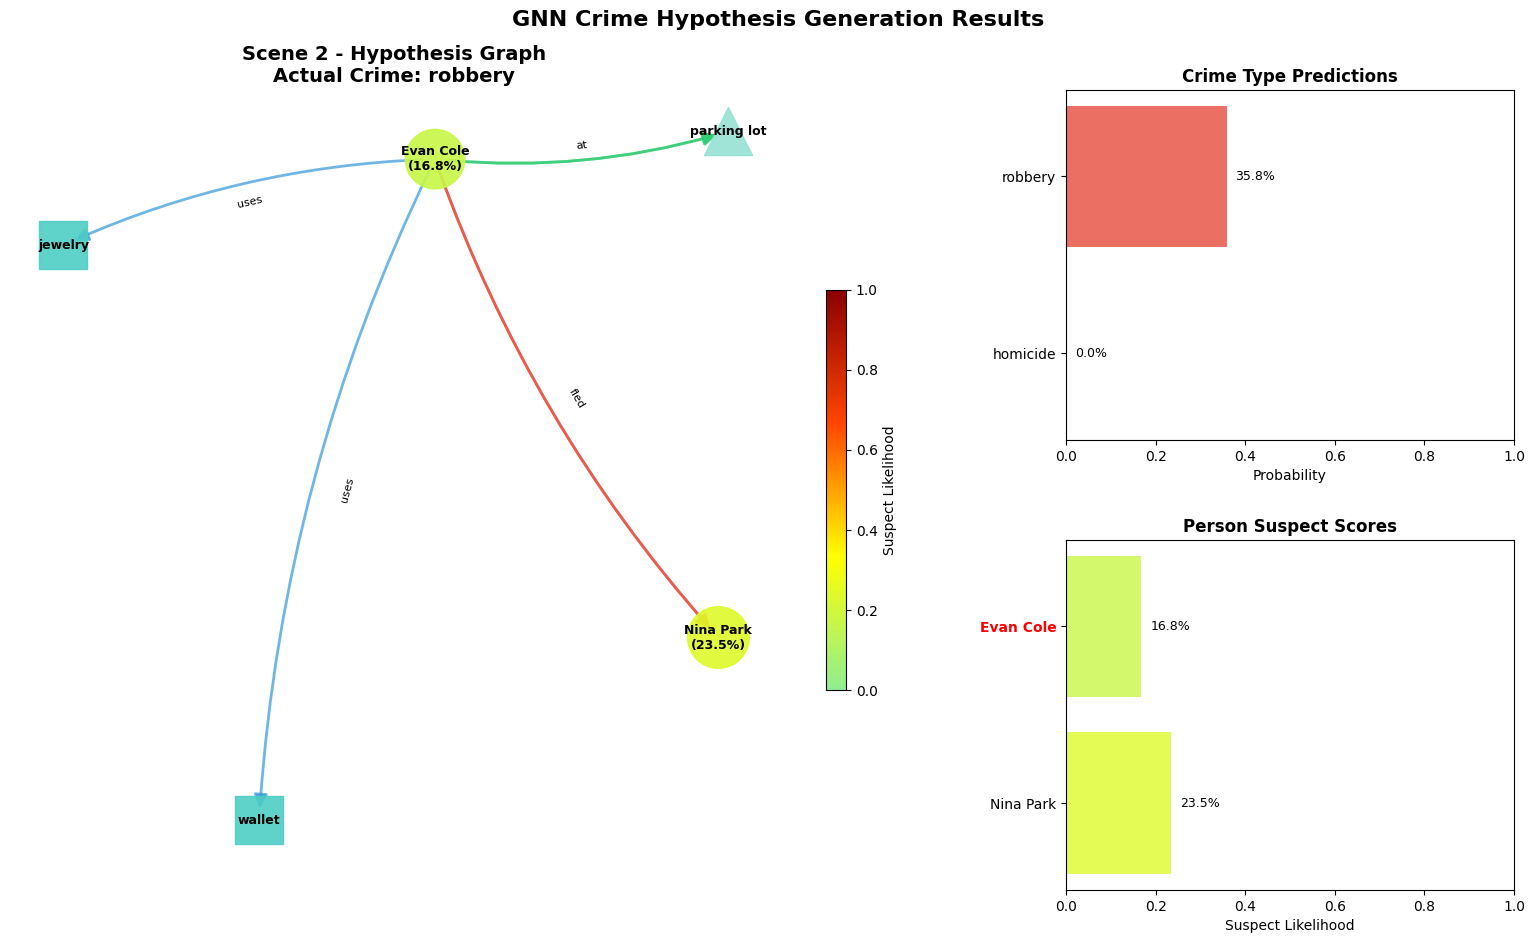


HYPOTHESIS SUMMARY

Actual Crime Type: robbery
Actual Suspect: Evan Cole

Top Crime Prediction: robbery
Top Suspect: Nina Park


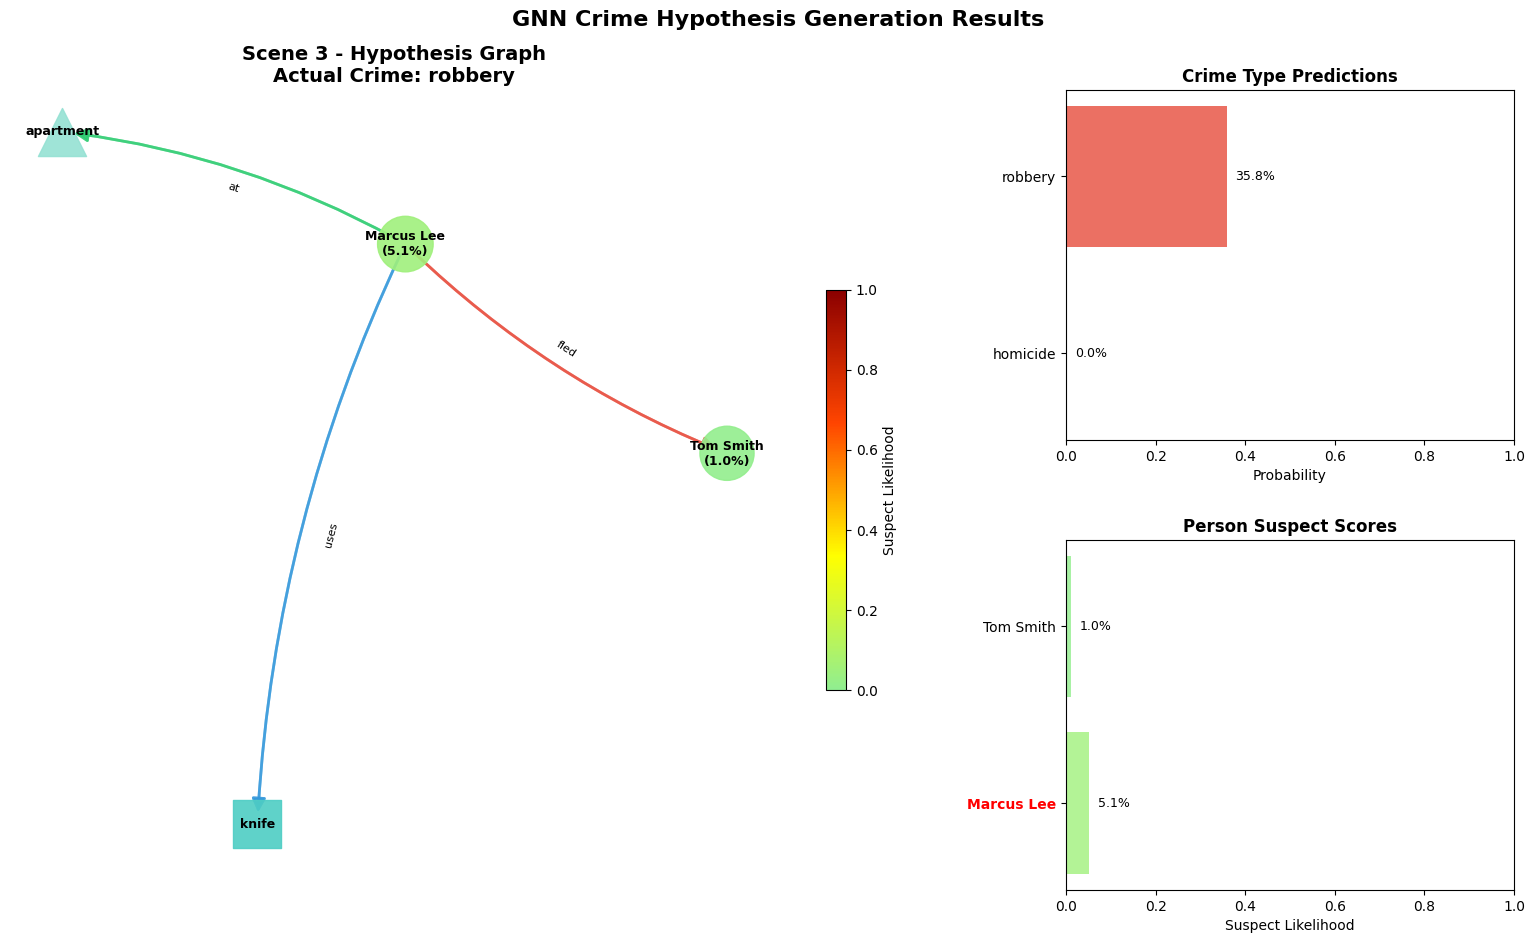


HYPOTHESIS SUMMARY

Actual Crime Type: robbery
Actual Suspect: Marcus Lee

Top Crime Prediction: robbery
Top Suspect: Marcus Lee
Visualization saved to hypothesis.png


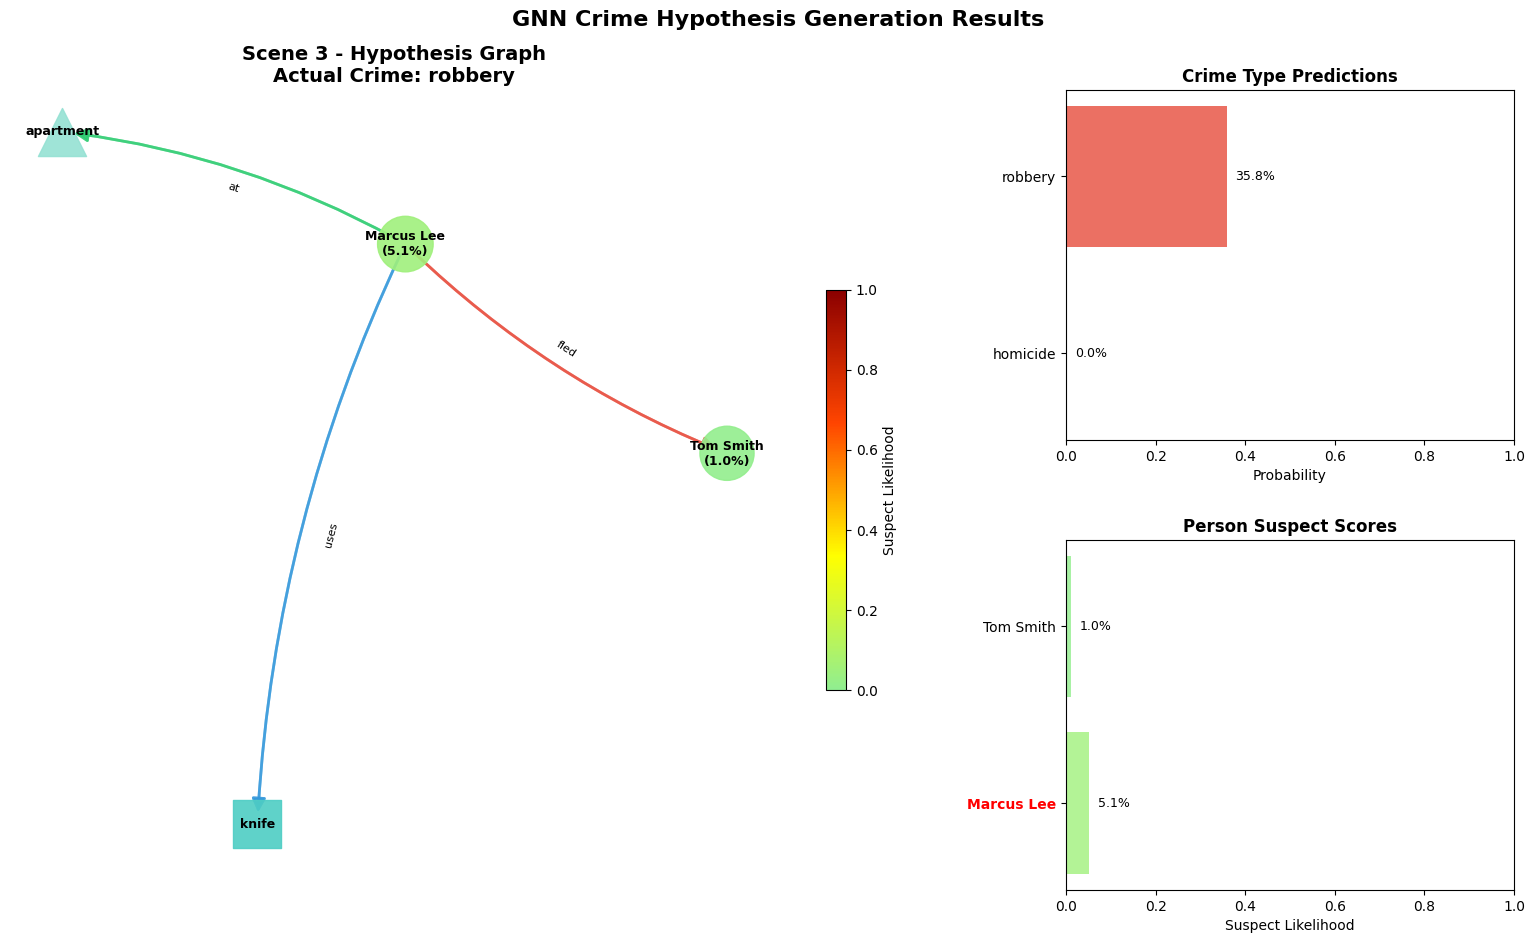


HYPOTHESIS SUMMARY

Actual Crime Type: robbery
Actual Suspect: Marcus Lee

Top Crime Prediction: robbery
Top Suspect: Marcus Lee


In [52]:
if __name__ == '__main__':
    dm = DataManager("/Users/rohitbogulla/Desktop/Sem 3/Applied ML 2/CrimeLens/data")
    df = dm.getData()
    main(df)